In [22]:
import geopandas as gpd
import pandas as pd

In [5]:
# Check whether LSOA area needs to be calculated or read directly
import geopandas as gpd
import os

# Use relative path to reference the shapefile folder
folder_path = os.path.join(os.getcwd(), 'LB_LSOA2021_shp')

# Get all .shp file paths
shapefiles = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.shp')]

# Read a shapefile and check field information
sample_shapefile = gpd.read_file(shapefiles[0])
print(sample_shapefile.columns)  # View field information
print(sample_shapefile.head())

# Check if the area field exists
if 'AREA' in sample_shapefile.columns or 'Shape_Area' in sample_shapefile.columns:
    print("Shapefile already contains LSOA area data")
else:
    print("Area needs to be calculated")


Index(['lsoa21cd', 'lsoa21nm', 'msoa21cd', 'msoa21nm', 'lad22cd', 'lad22nm',
       'geometry'],
      dtype='object')
    lsoa21cd                   lsoa21nm   msoa21cd                  msoa21nm  \
0  E01000011  Barking and Dagenham 016C  E02000017  Barking and Dagenham 016   
1  E01000046  Barking and Dagenham 017D  E02000018  Barking and Dagenham 017   
2  E01000051  Barking and Dagenham 021D  E02000022  Barking and Dagenham 021   
3  E01000077  Barking and Dagenham 008F  E02000009  Barking and Dagenham 008   
4  E01000083  Barking and Dagenham 007F  E02000008  Barking and Dagenham 007   

     lad22cd               lad22nm  \
0  E09000002  Barking and Dagenham   
1  E09000002  Barking and Dagenham   
2  E09000002  Barking and Dagenham   
3  E09000002  Barking and Dagenham   
4  E09000002  Barking and Dagenham   

                                            geometry  
0  POLYGON ((544607.954 184727.846, 544620.667 18...  
1  POLYGON ((547258.972 184378.376, 547259.861 18...  
2  POL

In [ ]:
# Manually calculate area
import geopandas as gpd
import os
import pandas as pd

# Set relative path, assuming `LB_LSOA2021_shp` is in the same directory as the current notebook file
folder_path = os.path.join(os.getcwd(), 'LB_LSOA2021_shp')

# Get all .shp file paths
shapefiles = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.shp')]

# Target coordinate reference system (British National Grid EPSG:27700)
target_crs = "EPSG:27700"

# Create an empty list to store LSOA calculation results
all_lsoa_areas = []

for shp in shapefiles:
    # Read the shapefile
    gdf = gpd.read_file(shp)
    
    # Retain only necessary columns and remove unnecessary variables
    gdf = gdf[['lsoa21cd', 'lsoa21nm', 'geometry']]

    # Check if the coordinate system matches the target CRS
    if gdf.crs is None:
        print(f"Warning: The file {shp} has no coordinate system, which may lead to inaccurate area calculations. Please check the file!")
    elif gdf.crs != target_crs:
        print(f"Transforming coordinate system: {shp} from {gdf.crs} to {target_crs}")
        gdf = gdf.to_crs(target_crs)
    else:
        print(f"Coordinate system matched: {shp}")

    # Calculate area (square meters)
    gdf['area_sqm'] = gdf['geometry'].area

    # Store the results in the list
    all_lsoa_areas.append(gdf)

# Combine all LSOA data
lsoa_areas = pd.concat(all_lsoa_areas, ignore_index=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4994 entries, 0 to 4993
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   lsoa21cd  4994 non-null   object  
 1   lsoa21nm  4994 non-null   object  
 2   geometry  4994 non-null   geometry
 3   area_sqm  4994 non-null   float64 
dtypes: float64(1), geometry(1), object(2)
memory usage: 156.2+ KB
None
    lsoa21cd                   lsoa21nm  \
0  E01000011  Barking and Dagenham 016C   
1  E01000046  Barking and Dagenham 017D   
2  E01000051  Barking and Dagenham 021D   
3  E01000077  Barking and Dagenham 008F   
4  E01000083  Barking and Dagenham 007F   

                                            geometry       area_sqm  
0  POLYGON ((544607.954 184727.846, 544620.667 18...   91632.281525  
1  POLYGON ((547258.972 184378.376, 547259.861 18...  155494.033603  
2  POLYGON ((544603.471 183903.184, 544620.396 18...   66632.494899  
3  POLYGON ((547548.035 185377.027,

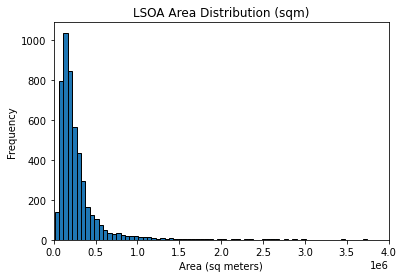

In [12]:
#Check the data
import matplotlib.pyplot as plt
print(lsoa_areas.info())
print(lsoa_areas.head())

plt.hist(lsoa_areas['area_sqm'], bins=300, edgecolor='black')
plt.title("LSOA Area Distribution (sqm)")
plt.xlabel("Area (sq meters)")
plt.ylabel("Frequency")
plt.xlim(0, 4e6) 
plt.show()

In [18]:
# Calculate the proportion of green space, the number of access points per square meter of green space, and their interaction term
import geopandas as gpd
import pandas as pd
import fiona
from sklearn.preprocessing import MinMaxScaler

# Set data paths
shapefile_path = "LB_LSOA2021_shp"
greenspace_path = "GB_GreenspaceSite.shp"
access_points_path = "GB_AccessPoint.shp"

# Iterate through and load all LSOA layers, merging them into a single GeoDataFrame
layers = fiona.listlayers(shapefile_path)
lsoa_gdfs = [gpd.read_file(shapefile_path, layer=layer)[['lsoa21cd', 'geometry']] for layer in layers]
lsoa = gpd.GeoDataFrame(pd.concat(lsoa_gdfs, ignore_index=True))

# Ensure consistency of lsoa21cd with lsoa_areas ID
lsoa['lsoa21cd'] = lsoa['lsoa21cd'].str.strip()

# Read greenspace and access points data
greenspace = gpd.read_file(greenspace_path)
access_points = gpd.read_file(access_points_path)

# Ensure all data uses the British National Grid coordinate system EPSG:27700
target_crs = "EPSG:27700"
if lsoa.crs != target_crs:
    lsoa = lsoa.to_crs(target_crs)
if greenspace.crs != target_crs:
    greenspace = greenspace.to_crs(target_crs)
if access_points.crs != target_crs:
    access_points = access_points.to_crs(target_crs)

# Calculate the green space area within each LSOA, set greenspace_area to 0 if none exists
lsoa['greenspace_area'] = lsoa.geometry.apply(lambda x: greenspace[greenspace.intersects(x)].geometry.area.sum())

# Ensure no NaN values when green space area is 0
lsoa['greenspace_area'].fillna(0, inplace=True)

# Calculate the proportion of green space (if no green space, the result is 0)
lsoa['greenspace_ratio'] = lsoa['greenspace_area'] / lsoa['geometry'].area
lsoa['greenspace_ratio'].fillna(0, inplace=True)

# Count the number of access points within each LSOA, set to 0 if none exist
lsoa['access_point_count'] = lsoa.geometry.apply(lambda x: access_points[access_points.within(x)].shape[0])
lsoa['access_point_count'].fillna(0, inplace=True)

# Calculate access point density per square meter of green space, avoiding division by 0
lsoa['access_point_density'] = lsoa.apply(lambda row: row['access_point_count'] / row['greenspace_area'] 
                                          if row['greenspace_area'] > 0 else 0, axis=1)

# Ensure infinity and missing values are handled
lsoa['access_point_density'].replace([float('inf'), -float('inf')], 0, inplace=True)
lsoa['access_point_density'].fillna(0, inplace=True)

# Standardize greenspace_ratio and access_point_density
scaler = StandardScaler()
lsoa[['greenspace_ratio_scaled', 'access_point_density_scaled']] = scaler.fit_transform(
    lsoa[['greenspace_ratio', 'access_point_density']]
)

# Calculate interaction term (product of standardized variables)
lsoa['greenspace_access_interaction'] = lsoa['greenspace_ratio_scaled'] * lsoa['access_point_density_scaled']

# Select required variables
lsoa_selected = lsoa[['lsoa21cd', 'greenspace_ratio', 'access_point_density', 'greenspace_access_interaction']]

# Merge and temporarily save data
# Ensure consistency of lsoa21cd to prevent potential matching issues
lsoa_areas['lsoa21cd'] = lsoa_areas['lsoa21cd'].str.strip()

# Merge new green space variables into the lsoa_areas dataset
final_lsoa_areas = lsoa_areas.merge(lsoa_selected, on='lsoa21cd', how='left')

# Check for missing values in the merged dataset
print(final_lsoa_areas.isna().sum())

# Display sample data
print(final_lsoa_areas.info())
print(final_lsoa_areas.head())

# Save the final dataset
final_lsoa_areas.to_csv("Final_LSOA_areas.csv", index=False)


lsoa21cd                         0
lsoa21nm                         0
geometry                         0
area_sqm                         0
greenspace_ratio                 0
access_point_density             0
greenspace_access_interaction    0
dtype: int64
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4994 entries, 0 to 4993
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   lsoa21cd                       4994 non-null   object  
 1   lsoa21nm                       4994 non-null   object  
 2   geometry                       4994 non-null   geometry
 3   area_sqm                       4994 non-null   float64 
 4   greenspace_ratio               4994 non-null   float64 
 5   access_point_density           4994 non-null   float64 
 6   greenspace_access_interaction  4994 non-null   float64 
dtypes: float64(4), geometry(1), object(2)
memory usage: 312.1+ KB
None
    lso

In [21]:
# Calculate police coverage
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon, MultiPolygon
import os
from shapely.wkt import loads
import fiona

# Set data paths
shapefile_path = "LB_LSOA2021_shp"

# Iterate through and load all LSOA layers, merging them into a single GeoDataFrame
layers = fiona.listlayers(shapefile_path)
lsoa_gdfs = [gpd.read_file(shapefile_path, layer=layer)[['lsoa21cd', 'geometry']] for layer in layers]
lsoa_gdf = gpd.GeoDataFrame(pd.concat(lsoa_gdfs, ignore_index=True))

# Ensure consistency of lsoa21cd with lsoa_areas ID
lsoa_gdf['lsoa21cd'] = lsoa_gdf['lsoa21cd'].str.strip()

# Ensure all data uses the British National Grid coordinate system EPSG:27700
target_crs = "EPSG:27700"
if lsoa_gdf.crs != target_crs:
    lsoa_gdf = lsoa_gdf.to_crs(target_crs)

print("Merge completed")

# Read KML files (police coverage areas)
def read_kml_to_gdf(kml_file):
    return gpd.read_file(kml_file, driver='KML')[['geometry']]

city_kml_path = os.path.join(os.getcwd(), 'city-of-london.kml')
metropolitan_kml_path = os.path.join(os.getcwd(), 'metropolitan.kml')

city_police_gdf = read_kml_to_gdf(city_kml_path)
metropolitan_police_gdf = read_kml_to_gdf(metropolitan_kml_path)

# Merge the two police coverage areas
police_gdf = gpd.GeoDataFrame(pd.concat([city_police_gdf, metropolitan_police_gdf], ignore_index=True))

# Ensure all data uses the same coordinate system, converting to British National Grid EPSG:27700
target_crs = "EPSG:27700"
police_gdf = police_gdf.to_crs(target_crs)

# Calculate the intersection area between each LSOA region and the police coverage area
def calculate_police_coverage(lsoa_row, police_geometry):
    intersection = lsoa_row['geometry'].intersection(police_geometry.unary_union)
    return intersection.area / lsoa_row['geometry'].area

# Calculate police coverage percentage
lsoa_gdf['police_coverage_ratio'] = lsoa_gdf.apply(lambda row: calculate_police_coverage(row, police_gdf), axis=1)

print(lsoa_gdf.info())
print(lsoa_gdf.head())

# Output the merged LSOA data, including police coverage ratio
final_lsoa_file = 'Final_LSOA_areas.csv'
final_lsoa_df = pd.read_csv(final_lsoa_file)

# Ensure column names are consistent and remove any possible spaces
final_lsoa_df.columns = final_lsoa_df.columns.str.strip()
lsoa_gdf.columns = lsoa_gdf.columns.str.strip()

# Merge data using 'lsoa21cd' as the matching key
final_lsoa_df = final_lsoa_df.merge(
    lsoa_gdf[['lsoa21cd', 'police_coverage_ratio']],
    on='lsoa21cd',
    how='left'
)

# Save the merged data
output_file = 'Final_LSOA_areas.csv'
final_lsoa_df.to_csv(output_file, index=False)

print("Merge completed, results saved to:", output_file)


合并完成，结果已保存到: Final_LSOA_areas.csv


In [ ]:
# Calculate nighttime light intensity
# First, merge LSOA region images
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os
from rasterio.plot import show
import fiona

# Set data path
shapefile_path = "LB_LSOA2021_shp"

# Iterate through and load all LSOA layers, merging them into a single GeoDataFrame
layers = fiona.listlayers(shapefile_path)
lsoa_gdfs = [gpd.read_file(shapefile_path, layer=layer)[['lsoa21cd', 'geometry']] for layer in layers]
lsoa_gdf = gpd.GeoDataFrame(pd.concat(lsoa_gdfs, ignore_index=True))

# Ensure consistency of lsoa21cd with lsoa_areas ID
lsoa_gdf['lsoa21cd'] = lsoa_gdf['lsoa21cd'].str.strip()

# Ensure all data uses the British National Grid coordinate system EPSG:27700
target_crs = "EPSG:27700"
if lsoa_gdf.crs != target_crs:
    lsoa_gdf = lsoa_gdf.to_crs(target_crs)
    
print("Merge completed")


In [4]:
import os
import glob
import rasterio
from rasterio.merge import merge
from rasterio.mask import mask
import geopandas as gpd

# Set file paths
b04_folder = os.path.join(".", "B04")  # B04 folder
b08_folder = os.path.join(".", "B08")  # B08 folder

# Function: Merge JP2 images
def merge_jp2_files(folder_path):
    jp2_files = glob.glob(os.path.join(folder_path, "*.jp2"))  # Get all JP2 file paths

    src_files_to_mosaic = []
    for file in jp2_files:
        src = rasterio.open(file)  # Open files directly without using with statement
        src_files_to_mosaic.append(src)

    # Merge images
    mosaic, out_trans = merge(src_files_to_mosaic)

    # Get image metadata
    out_meta = src_files_to_mosaic[0].meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_trans
    })

    # Close all opened image files
    for src in src_files_to_mosaic:
        src.close()

    return mosaic, out_meta

# Merge B04 and B08 band images
print("Merging B04 images...")
b04_mosaic, b04_meta = merge_jp2_files(b04_folder)
print("Merging B08 images...")
b08_mosaic, b08_meta = merge_jp2_files(b08_folder)

for key, value in b04_meta.items():
    print(f"{key}: {value}")


合并 B04 影像...
合并 B08 影像...
driver: GTiff
dtype: uint16
nodata: None
width: 20976
height: 20982
count: 1
crs: EPSG:32630
transform: | 10.00, 0.00, 600000.00|
| 0.00,-10.00, 5800020.00|
| 0.00, 0.00, 1.00|


In [ ]:
# Function: Clip images to LSOA areas and calculate average intensity
lsoa_gdf = lsoa_gdf.to_crs(epsg=32630)
print("Transformed coordinate system:", lsoa_gdf.crs)

import rasterio
from rasterio.mask import mask
import tempfile
import numpy as np

def calculate_lsoa_light_intensity(mosaic, meta, lsoa_gdf):
    intensity_values = []

    # Create a temporary file to store TIFF to reduce memory usage
    with tempfile.NamedTemporaryFile(suffix=".tif", delete=False) as tmpfile:
        with rasterio.open(tmpfile.name, 'w', **meta) as dest:
            dest.write(mosaic)

        # Reopen the TIFF file and clip it by LSOA areas
        with rasterio.open(tmpfile.name) as src:
            for idx, row in lsoa_gdf.iterrows():
                geom = [row['geometry']]
                try:
                    out_image, out_transform = mask(src, geom, crop=True)
                    mean_intensity = np.nanmean(out_image)  # Use np.nanmean to ignore invalid values
                except Exception as e:
                    mean_intensity = 0  # Handle invalid areas

                intensity_values.append(mean_intensity)

    return intensity_values

# Calculate red light (B04) and near-infrared (B08) intensity for each LSOA
print("Calculating LSOA red light (B04) intensity...")
lsoa_gdf['B04_intensity'] = calculate_lsoa_light_intensity(b04_mosaic, b04_meta, lsoa_gdf)

print("Calculating LSOA near-infrared (B08) intensity...")
lsoa_gdf['B08_intensity'] = calculate_lsoa_light_intensity(b08_mosaic, b08_meta, lsoa_gdf)

# Calculate the Nighttime Light Index (NDLI)
lsoa_gdf['NDLI'] = (lsoa_gdf['B04_intensity'] - lsoa_gdf['B08_intensity']) / (lsoa_gdf['B04_intensity'] + lsoa_gdf['B08_intensity'] + 1e-10)

print("Calculation completed")


              NDLI
count  4994.000000
mean      0.518016
std       0.143500
min       0.000000
25%       0.430768
50%       0.536946
75%       0.620925
max       1.000000
LSOA 夜间灯光强度计算完成，结果已保存。


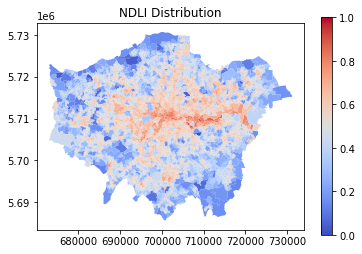

In [8]:
# Normalize nighttime light intensity
from sklearn.preprocessing import MinMaxScaler
import geopandas as gpd

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Perform normalization
lsoa_gdf['NDLI_normalized'] = scaler.fit_transform(lsoa_gdf[['NDLI']])
lsoa_gdf['NDLI'] = lsoa_gdf['NDLI_normalized']
lsoa_gdf.drop(columns=['NDLI_normalized'], inplace=True)

# View basic statistics of the normalized data
print(lsoa_gdf[['NDLI']].describe())

# Save the normalized data
lsoa_gdf[['lsoa21cd', 'B04_intensity', 'B08_intensity', 'NDLI']].to_csv("lsoa_night_light.csv", index=False)

print("LSOA nighttime light intensity calculation completed, results saved.")

lsoa_gdf.plot(column='NDLI', cmap='coolwarm', legend=True)
plt.title('NDLI Distribution')
plt.show()
